In [1]:
from pathlib import Path
import sys
sys.path.insert(0, str(Path().absolute().parent))

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, metrics

from data.datasets import BinaryMixtures, COLOR_DICT
from data.data_functions import DataLoader, DerivTransform, NormalizeTransform
from data.experiment_parameters import (
        ExperimentFilter,
        Chamber, 
        Sensor, 
        InjectionTime, 
        InjectionRate, 
        InjectionVolume
)
from data.plot_functions import plot_array_data, get_gradient_colors, plot_regression
from data.utils import train_test_split, sort_by_set

SEED = 1

In [11]:
color = {"train": [0.5, 0.5, 0.5], "test": [0, 0, 0]}

## Pentane-Hexane

In [2]:
# Parameters
volume = 0.4
rate = 6.0
time = 4.0

In [3]:
filters = ExperimentFilter(Chamber.TALL, Sensor.SM30, InjectionTime(time), InjectionRate(rate), InjectionVolume(volume))
C5C6_set = BinaryMixtures(["Pentane", "Hexane"], filters=filters)

try:
    C5C6_set[1.0].remove(622)
except:
    pass

Load data

In [4]:
C5C6_derivs, C5C6_concentrations = DataLoader(C5C6_set, transforms=[DerivTransform,NormalizeTransform]).load()

Loading experimental data
(1/11) 0.0 (3 exp.): [===================0] 100% complete
(2/11) 0.1 (3 exp.): [===================0] 100% complete
(3/11) 0.2 (3 exp.): [===================0] 100% complete
(4/11) 0.3 (3 exp.): [===================0] 100% complete
(5/11) 0.4 (3 exp.): [===================0] 100% complete
(6/11) 0.5 (3 exp.): [===================0] 100% complete
(7/11) 0.6 (2 exp.): [===================0] 100% complete
(8/11) 0.7 (3 exp.): [===================0] 100% complete
(9/11) 0.8 (3 exp.): [===================0] 100% complete
(10/11) 0.9 (3 exp.): [===================0] 100% complete
(11/11) 1.0 (2 exp.): [===================0] 100% complete
Length of experimental set loaded: 31


## Pentane-Octane

In [5]:
# Parameters
volume = 1.3
rate = 6.0
time = 15.0

In [6]:
filters = ExperimentFilter(Chamber.TALL, Sensor.SM30, InjectionTime(time), InjectionRate(rate), InjectionVolume(volume))
C5C8_set = BinaryMixtures(["Pentane", "Octane"], filters=filters)

coop_set = [241, 242, 243, 244, 245, 247] + [208,209,283,174,203] + [216,217,273,218,219,220,230,272,274,279,233,236,434,435] + [n for n in range(386,401)]
# for key, values in C5C8_set.items():
#     for value in [num for num in values if num not in coop_set]:
#         print(value)
#         C5C8_set[key].remove(value)

removed = [
    (0.0, 151), (0.2, 246), (0.4, 248), (0.4, 249), (0.4, 250), 
    (0.6, 251), (0.6, 252), (0.6, 253), (0.8, 256), (0.8, 254), (0.8, 255),
    (0.95, 275), (1.0, 239), (1.0, 240), (1.0, 148)
]
for key, value in removed:
    C5C8_set[key].remove(value)
    
# remove empty sets
for key in list(C5C8_set.keys()):
    if not C5C8_set[key]:
        C5C8_set.pop(key)
#train_set, test_set = train_test_split(exp_set)

In [7]:
C5C8_derivs, C5C8_concentrations = DataLoader(C5C8_set, transforms=[DerivTransform,NormalizeTransform]).load()

Loading experimental data
(1/14) 0.0 (6 exp.): [===================0] 100% complete
(2/14) 0.1 (3 exp.): [===================0] 100% complete
(3/14) 0.2 (2 exp.): [===================0] 100% complete
(4/14) 0.25 (2 exp.): [===================0] 100% complete
(5/14) 0.3 (2 exp.): [===================0] 100% complete
(6/14) 0.33 (1 exp.): [===================0] 100% complete
(7/14) 0.5 (5 exp.): [===================0] 100% complete
(8/14) 0.6 (1 exp.): [===================0] 100% complete
(9/14) 0.67 (1 exp.): [===================0] 100% complete
(10/14) 0.7 (4 exp.): [===================0] 100% complete
(11/14) 0.75 (2 exp.): [===================0] 100% complete
(12/14) 0.8 (1 exp.): [===================0] 100% complete
(13/14) 0.9 (3 exp.): [===================0] 100% complete
(14/14) 1.0 (4 exp.): [===================0] 100% complete
Length of experimental set loaded: 37


# Create plot

In [8]:
# split Hexane dataset
C5C6_train_set, C5C6_test_set = train_test_split(C5C6_set, test_size=1/2.5, seed=SEED)
C5C6_train, C5C6_train_lbl, C5C6_test, C5C6_test_lbl = sort_by_set(C5C6_derivs, C5C6_train_set, C5C6_test_set)

# split Octane dataset
C5C8_train_set, C5C8_test_set = train_test_split(C5C8_set, test_size=1/2.5, seed=SEED)
C5C8_train, C5C8_train_lbl, C5C8_test, C5C8_test_lbl = sort_by_set(C5C8_derivs, C5C8_train_set, C5C8_test_set)


Create SVR

In [9]:
SVR = {}
model = {}
kernel = 'rbf'

def train_SVR(train_derivs, train_lbl, kernel='rbf', C=1, gamma=1):
    SVR = svm.SVR(C=C,gamma=gamma, kernel=kernel)
    SVR.fit(train_derivs, train_lbl)

    print("Training accuracy: " + str(SVR.score(train_derivs, train_lbl)) + " (" + str(len(train_lbl)) + ")")
    return SVR

# train simple SVR
print("Pentane-Hexane")
SVR["C5C6"] = train_SVR(C5C6_train, C5C6_train_lbl, kernel=kernel, C=10, gamma=3)
print(f"Testing accuracy: {SVR['C5C6'].score(C5C6_test, C5C6_test_lbl)}")

print()

print("Pentane-Octane")
SVR["C5C8"] = train_SVR(C5C8_train, C5C8_train_lbl, kernel=kernel, C=10, gamma=3)
print(f"Testing accuracy: {SVR['C5C8'].score(C5C8_test, C5C8_test_lbl)}")

Pentane-Hexane
Training accuracy: 0.8681410838757629 (22)
Testing accuracy: 0.8128782066777687

Pentane-Octane
Training accuracy: 0.9526429739803471 (29)
Testing accuracy: 0.9776315171181492


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


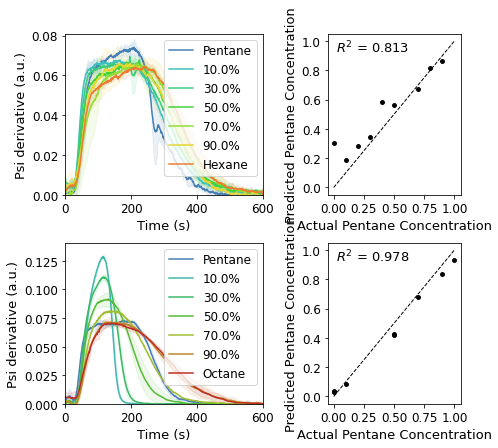

In [12]:
labelsize = 13
legendsize = 12
ticksize = 12

widths = [4, 2.69291]
heights = [3, 3]
fig, ax = plt.subplots(nrows=len(heights), ncols=len(widths), sharex=False, sharey=False, gridspec_kw={'height_ratios': heights, 'width_ratios': widths}, figsize=(sum(widths),sum(heights)));
#gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

# divide figure into suplots
axB = ax[0,:] #[fig.add_subplot(gs[0, c]) for c in range(0,4)]
axC = ax[1,:] #[fig.add_subplot(gs[-1, c]) for c in range(0,4)]

# add phase derivative plots
conc_list = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
colors = {conc:col for conc,col in zip(conc_list, get_gradient_colors(len(conc_list), COLOR_DICT["Hexane"], COLOR_DICT["Pentane"]))}
plot_array_data({k:v for k,v in sorted(C5C6_set.items(), reverse=True) if k in conc_list}, C5C6_derivs, xlim=[0, 600], ylim=[0,0.081], color_dict=colors, ax = axB[0])
colors = {conc:col for conc,col in zip(conc_list, get_gradient_colors(len(conc_list), COLOR_DICT["Octane"], COLOR_DICT["Pentane"]))}
plot_array_data({k:v for k,v in sorted(C5C8_set.items(), reverse=True) if k in conc_list}, C5C8_derivs, xlim=[0, 600], ylim=[0,0.141], color_dict=colors, ax = axC[0])

axB[0].set_xlabel("Time (s)", fontsize=labelsize)
axC[0].set_xlabel("Time (s)", fontsize=labelsize)
axB[0].set_ylabel("Psi derivative (a.u.)", fontsize=labelsize)
axC[0].set_ylabel("Psi derivative (a.u.)", fontsize=labelsize)
axB[0].tick_params(labelsize=ticksize)
axC[0].tick_params(labelsize=ticksize)
axB[0].legend(["Pentane"] + [f"{c*100}%" for c in conc_list[1:-1]] + ["Hexane"], fontsize=legendsize)
axC[0].legend(["Pentane"] + [f"{c*100}%" for c in conc_list[1:-1]] + ["Octane"], fontsize=legendsize)

# add SVR regression plots
plot_regression(C5C6_test_lbl, SVR['C5C6'].predict(C5C6_test), c=color['test'], ax = axB[1], labelsize=labelsize, ticksize=ticksize)
plot_regression(C5C8_test_lbl, SVR['C5C8'].predict(C5C8_test), c=color['test'], ax = axC[1], labelsize=labelsize, ticksize=ticksize)
axB[1].xaxis.set_ticks([0.0,0.25,0.5,0.75,1.0])
axC[1].xaxis.set_ticks([0.0,0.25,0.5,0.75,1.0])

plt.tight_layout()
#fig.savefig('./Figure-4 JN.svg', format='svg', dpi=1200)

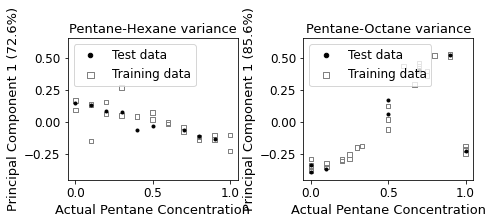

In [13]:
from sklearn.decomposition import PCA

def plot_pc1(train_derivs, train_lbl, test_derivs, test_lbl, ax = None):
    # plot segmented regression results
    if ax == None:
        plt.figure(figsize = (5,5))
        ax = plt.gca()
    
    # calculate PCA
    pca = PCA(n_components=2)
    train_pca = pca.fit_transform(train_derivs)
    test_pca = pca.transform(test_derivs)
    
    # Plot data
    ax.plot(np.array(test_lbl),np.array(test_pca[:, 0]), '.', c=color["test"], label = "Test data")
    ax.scatter(train_lbl, train_pca[:, 0],c='None', marker='s',s=20,edgecolors=color["train"],linewidths=1, label = "Training data")
    
    ax.set_xlabel('Actual Pentane Concentration', fontsize = labelsize)
    ax.set_ylabel(f'Principal Component 1 ({round(pca.explained_variance_ratio_[0]*100, 1)}%)', fontsize = labelsize)
    ax.tick_params(direction='out', top = False, bottom = True, left = True, right = False, labelsize = ticksize)

    ax.legend(loc='upper left', fontsize = legendsize, markerscale = 1.5)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.45, 0.65])

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(6.69291, 3))

plot_pc1(C5C6_train, C5C6_train_lbl, C5C6_test, C5C6_test_lbl, ax = ax[0])
plot_pc1(C5C8_train, C5C8_train_lbl, C5C8_test, C5C8_test_lbl, ax = ax[1])

ax[0].set_title("Pentane-Hexane variance", fontsize=labelsize)
ax[1].set_title("Pentane-Octane variance", fontsize=labelsize)

plt.tight_layout()
#fig.savefig('./Figure-4 variance supplement.svg', format='svg', dpi=1200)

### Modified training
Removing outlier in C5C6 dataset

In [14]:
SVR = {}
model = {}
kernel = 'rbf'

def train_SVR(train_derivs, train_lbl, kernel='rbf', C=1, gamma=1):
    SVR = svm.SVR(C=C,gamma=gamma, kernel=kernel)
    SVR.fit(train_derivs, train_lbl)

    print("Training accuracy: " + str(SVR.score(train_derivs, train_lbl)) + " (" + str(len(train_lbl)) + ")")
    return SVR

# train simple SVR
print("Pentane-Hexane")
SVR["C5C6"] = train_SVR(C5C6_train, C5C6_train_lbl, kernel=kernel, C=10, gamma=3)
print(f"Testing accuracy: {SVR['C5C6'].score(C5C6_test[1:], C5C6_test_lbl[1:])}")

print()

print("Pentane-Octane")
SVR["C5C8"] = train_SVR(C5C8_train, C5C8_train_lbl, kernel=kernel, C=10, gamma=3)
print(f"Testing accuracy: {SVR['C5C8'].score(C5C8_test, C5C8_test_lbl)}")

Pentane-Hexane
Training accuracy: 0.8681410838757629 (22)
Testing accuracy: 0.9040886925471199

Pentane-Octane
Training accuracy: 0.9526429739803471 (29)
Testing accuracy: 0.9776315171181492


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


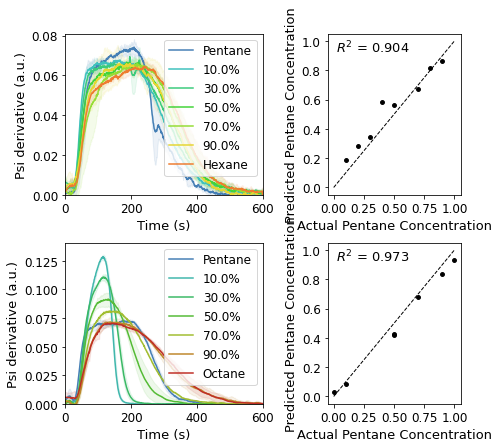

In [15]:
from matplotlib import gridspec
widths = [4, 2.69291]
heights = [3, 3]
fig, ax = plt.subplots(nrows=len(heights), ncols=len(widths), sharex=False, sharey=False, gridspec_kw={'height_ratios': heights, 'width_ratios': widths}, figsize=(sum(widths),sum(heights)));
#gs = gridspec.GridSpec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

# divide figure into suplots
axB = ax[0,:] #[fig.add_subplot(gs[0, c]) for c in range(0,4)]
axC = ax[1,:] #[fig.add_subplot(gs[-1, c]) for c in range(0,4)]

# add phase derivative plots
conc_list = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
colors = {conc:col for conc,col in zip(conc_list, get_gradient_colors(len(conc_list), COLOR_DICT["Hexane"], COLOR_DICT["Pentane"]))}
plot_array_data({k:v for k,v in sorted(C5C6_set.items(), reverse=True) if k in conc_list}, C5C6_derivs, xlim=[0, 600], ylim=[0,0.081], color_dict=colors, ax = axB[0])
colors = {conc:col for conc,col in zip(conc_list, get_gradient_colors(len(conc_list), COLOR_DICT["Octane"], COLOR_DICT["Pentane"]))}
plot_array_data({k:v for k,v in sorted(C5C8_set.items(), reverse=True) if k in conc_list}, C5C8_derivs, xlim=[0, 600], ylim=[0,0.141], color_dict=colors, ax = axC[0])

axB[0].set_xlabel("Time (s)", fontsize=labelsize)
axC[0].set_xlabel("Time (s)", fontsize=labelsize)
axB[0].set_ylabel("Psi derivative (a.u.)", fontsize=labelsize)
axC[0].set_ylabel("Psi derivative (a.u.)", fontsize=labelsize)
axB[0].tick_params(labelsize=ticksize)
axC[0].tick_params(labelsize=ticksize)
axB[0].legend(["Pentane"] + [f"{c*100}%" for c in conc_list[1:-1]] + ["Hexane"], fontsize=legendsize)
axC[0].legend(["Pentane"] + [f"{c*100}%" for c in conc_list[1:-1]] + ["Octane"], fontsize=legendsize)

# add SVR regression plots
plot_regression(C5C6_test_lbl[1:], SVR['C5C6'].predict(C5C6_test[1:]), c=color['test'], ax = axB[1], labelsize=labelsize, ticksize=ticksize)
plot_regression(C5C8_test_lbl[1:], SVR['C5C8'].predict(C5C8_test[1:]), c=color['test'], ax = axC[1], labelsize=labelsize, ticksize=ticksize)
axB[1].xaxis.set_ticks([0.0,0.25,0.5,0.75,1.0])
axC[1].xaxis.set_ticks([0.0,0.25,0.5,0.75,1.0])

plt.tight_layout()
#fig.savefig('./Figure (outlier removed).svg', format='svg', dpi=1200)

## Supplementary figures

In [29]:
from sklearn.model_selection import train_test_split

def plot_learning_curve(estimator, exp_derivs, exp_concentrations, ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5, ax = None):
    if ax == None:
        fig, ax = plt.subplots()
    if M == None:
        M = np.arange(1,int(len(exp_derivs)*(1-test_size)))

    train_mean = []
    train_std = []
    test_mean = []
    test_std = []

    for m in M:
        train_score = []
        test_score = []
        for state in random_seeds:
            train_derivs, test_derivs, train_lbl, test_lbl = train_test_split(exp_derivs, exp_concentrations, test_size=test_size,random_state=state)
            derivs = train_derivs[0:m]
            lbls = train_lbl[0:m]
            if len(set(lbls)) < 2:
                continue
            if estimator != 'multi': # train SVR
                estimator.fit(derivs, lbls);
                score = estimator.score(test_derivs, test_lbl)
                
                if score > 0:
                    train_score.append(estimator.score(derivs, lbls))
                    test_score.append(estimator.score(test_derivs, test_lbl))
            else: 
                raise NotImplementedError

        train_mean.append(np.mean(train_score, axis=0))
        train_std.append(np.std(train_score, axis=0))
        test_mean.append(np.mean(test_score, axis=0))
        test_std.append(np.std(test_score, axis=0))

    ax.set_ylim(ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.fill_between(M , np.array(train_mean) - np.array(train_std),np.array(train_mean) + np.array(train_std), alpha=0.1,color="r")
    ax.fill_between(M, np.array(test_mean) - np.array(test_std),np.array(test_mean) + np.array(test_std), alpha=0.1, color="g")
    ax.plot(M, train_mean, 'o-', color="r",label="Training score")
    ax.plot(M, test_mean, 'o-', color="g",label="Cross-validation score")
    ax.grid()
    ax.legend(loc="lower right")

    print("Training accuracy: " + str(train_mean[-1]) + " (" + str(train_std[-1]) + ")")
    print("Validation accuracy: " + str(test_mean[-1]) + " (" + str(test_std[-1]) + ")")
    
    return test_mean, test_std, M

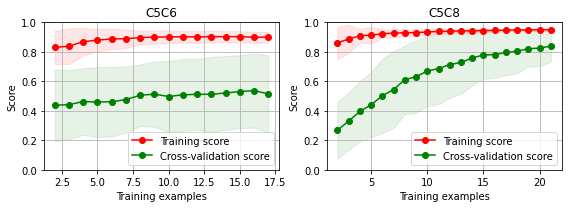

In [30]:
from IPython.utils import io

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(8,3))

avgN = 100

with io.capture_output() as captured:
    plot_learning_curve(SVR['C5C6'], list(C5C6_derivs.values()), list(C5C6_concentrations.values()), ylim=(0,1), random_seeds = np.arange(0,avgN), M = None, test_size = 1/2.5, ax = ax[0])
    plot_learning_curve(SVR['C5C8'], list(C5C8_derivs.values()), list(C5C8_concentrations.values()), ylim=(0,1), random_seeds = np.arange(0,avgN), M = None, test_size = 1/2.5, ax = ax[1])
    
ax[0].set_title('C5C6')
ax[1].set_title('C5C8')
fig.tight_layout()